In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

**<span style="font-size: 20px;">№1. Генерация данных для основной задачи</span>**

In [76]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                          n_redundant=5, n_classes=2, random_state=42)

**<span style="font-size: 16px;">Визуализация данных</span>**

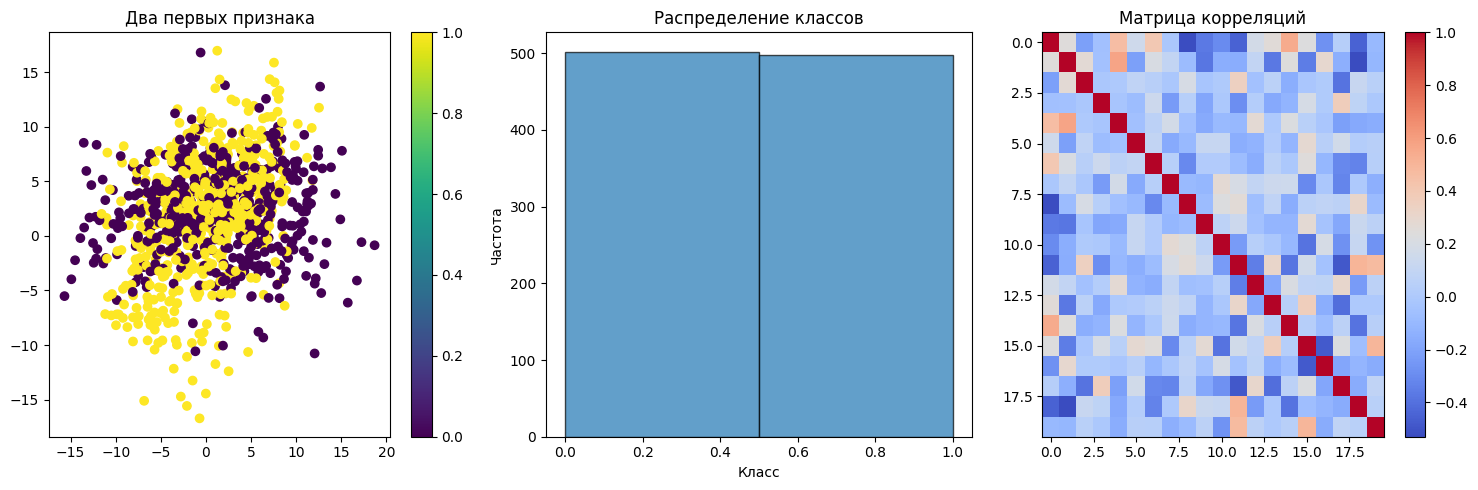

In [77]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Два первых признака')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.hist(y, bins=2, alpha=0.7, edgecolor='black')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
correlation_matrix = np.corrcoef(X.T)
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.title('Матрица корреляций')
plt.colorbar()

plt.tight_layout()
plt.show()

**<span style="font-size: 20px;">№2. Разделение данных на обучающую и тестовую выборки</span>**

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [79]:
# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
# Преобразование в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [81]:
# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**<span style="font-size: 20px;">№3. Построение нейронной сети для классификации</span>**

In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=2, dropout_rate=0.0):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

**<span style="font-size: 16px;">Функция для обучения модели</span>**

In [83]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=100):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Оценка на тестовых данных
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        accuracy = 100 * correct / total
        train_losses.append(total_loss / len(train_loader))
        test_accuracies.append(accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')
    
    return train_losses, test_accuracies

**<span style="font-size: 20px;">№4. Исследование различных оптимизаторов (без Dropout)</span>**

In [84]:
input_size = X_train.shape[1]
output_size = 2
epochs = 100

# Создание моделей с разными оптимизаторами
models_without_dropout = {}
optimizers_without_dropout = {}

**<span style="font-size: 16px;">SGD</span>**

In [85]:
model_sgd = NeuralNetwork(input_size, dropout_rate=0.0)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
models_without_dropout['SGD'] = model_sgd
optimizers_without_dropout['SGD'] = optimizer_sgd

**<span style="font-size: 16px;">Adam</span>**

In [86]:
model_adam = NeuralNetwork(input_size, dropout_rate=0.0)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
models_without_dropout['Adam'] = model_adam
optimizers_without_dropout['Adam'] = optimizer_adam

**<span style="font-size: 16px;">RMSProp</span>**

In [87]:
model_rmsprop = NeuralNetwork(input_size, dropout_rate=0.0)
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.001)
models_without_dropout['RMSProp'] = model_rmsprop
optimizers_without_dropout['RMSProp'] = optimizer_rmsprop

**<span style="font-size: 16px;">Обучение моделей без Dropout</span>**

In [88]:
results_without_dropout = {}
criterion = nn.CrossEntropyLoss()

for name, model in models_without_dropout.items():
    print(f"\nОбучение с оптимизатором {name}:")
    optimizer = optimizers_without_dropout[name]
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, 
                                               optimizer, criterion, epochs)
    results_without_dropout[name] = {
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'final_accuracy': test_accuracies[-1]
    }


Обучение с оптимизатором SGD:
Epoch [20/100], Loss: 0.4217, Accuracy: 87.00%
Epoch [40/100], Loss: 0.2344, Accuracy: 89.50%
Epoch [60/100], Loss: 0.1654, Accuracy: 91.50%
Epoch [80/100], Loss: 0.1237, Accuracy: 93.00%
Epoch [100/100], Loss: 0.0944, Accuracy: 94.50%

Обучение с оптимизатором Adam:
Epoch [20/100], Loss: 0.0448, Accuracy: 95.50%
Epoch [40/100], Loss: 0.0074, Accuracy: 96.00%
Epoch [60/100], Loss: 0.0021, Accuracy: 96.00%
Epoch [80/100], Loss: 0.0009, Accuracy: 96.50%
Epoch [100/100], Loss: 0.0005, Accuracy: 96.00%

Обучение с оптимизатором RMSProp:
Epoch [20/100], Loss: 0.0332, Accuracy: 96.50%
Epoch [40/100], Loss: 0.0032, Accuracy: 96.50%
Epoch [60/100], Loss: 0.0003, Accuracy: 96.00%
Epoch [80/100], Loss: 0.0000, Accuracy: 96.00%
Epoch [100/100], Loss: 0.0000, Accuracy: 96.50%


**<span style="font-size: 20px;">№5. Исследование с Dropout</span>**

In [89]:
models_with_dropout = {}
optimizers_with_dropout = {}

**<span style="font-size: 16px;">SGD с Dropout</span>**

In [90]:
model_sgd_dropout = NeuralNetwork(input_size, dropout_rate=0.3)
optimizer_sgd_dropout = optim.SGD(model_sgd_dropout.parameters(), lr=0.01)
models_with_dropout['SGD'] = model_sgd_dropout
optimizers_with_dropout['SGD'] = optimizer_sgd_dropout

**<span style="font-size: 16px;">Adam с Dropout</span>**

In [91]:
model_adam_dropout = NeuralNetwork(input_size, dropout_rate=0.3)
optimizer_adam_dropout = optim.Adam(model_adam_dropout.parameters(), lr=0.001)
models_with_dropout['Adam'] = model_adam_dropout
optimizers_with_dropout['Adam'] = optimizer_adam_dropout

**<span style="font-size: 16px;">RMSProp с Dropout</span>**

In [92]:
model_rmsprop_dropout = NeuralNetwork(input_size, dropout_rate=0.3)
optimizer_rmsprop_dropout = optim.RMSprop(model_rmsprop_dropout.parameters(), lr=0.001)
models_with_dropout['RMSProp'] = model_rmsprop_dropout
optimizers_with_dropout['RMSProp'] = optimizer_rmsprop_dropout

**<span style="font-size: 16px;">Обучение моделей с Dropout</span>**

In [93]:
results_with_dropout = {}

for name, model in models_with_dropout.items():
    print(f"\nОбучение с оптимизатором {name} и Dropout:")
    optimizer = optimizers_with_dropout[name]
    train_losses, test_accuracies = train_model(model, train_loader, test_loader, 
                                               optimizer, criterion, epochs)
    results_with_dropout[name] = {
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'final_accuracy': test_accuracies[-1]
    }


Обучение с оптимизатором SGD и Dropout:
Epoch [20/100], Loss: 0.5278, Accuracy: 86.50%
Epoch [40/100], Loss: 0.3597, Accuracy: 88.50%
Epoch [60/100], Loss: 0.2634, Accuracy: 89.50%
Epoch [80/100], Loss: 0.2097, Accuracy: 91.00%
Epoch [100/100], Loss: 0.1900, Accuracy: 92.00%

Обучение с оптимизатором Adam и Dropout:
Epoch [20/100], Loss: 0.1336, Accuracy: 93.00%
Epoch [40/100], Loss: 0.0860, Accuracy: 95.00%
Epoch [60/100], Loss: 0.0546, Accuracy: 95.50%
Epoch [80/100], Loss: 0.0537, Accuracy: 95.00%
Epoch [100/100], Loss: 0.0397, Accuracy: 96.00%

Обучение с оптимизатором RMSProp и Dropout:
Epoch [20/100], Loss: 0.1388, Accuracy: 95.50%
Epoch [40/100], Loss: 0.0829, Accuracy: 96.50%
Epoch [60/100], Loss: 0.0637, Accuracy: 96.50%
Epoch [80/100], Loss: 0.0649, Accuracy: 96.00%
Epoch [100/100], Loss: 0.0437, Accuracy: 96.50%


**<span style="font-size: 20px;">№6. Визуализация результатов</span>**

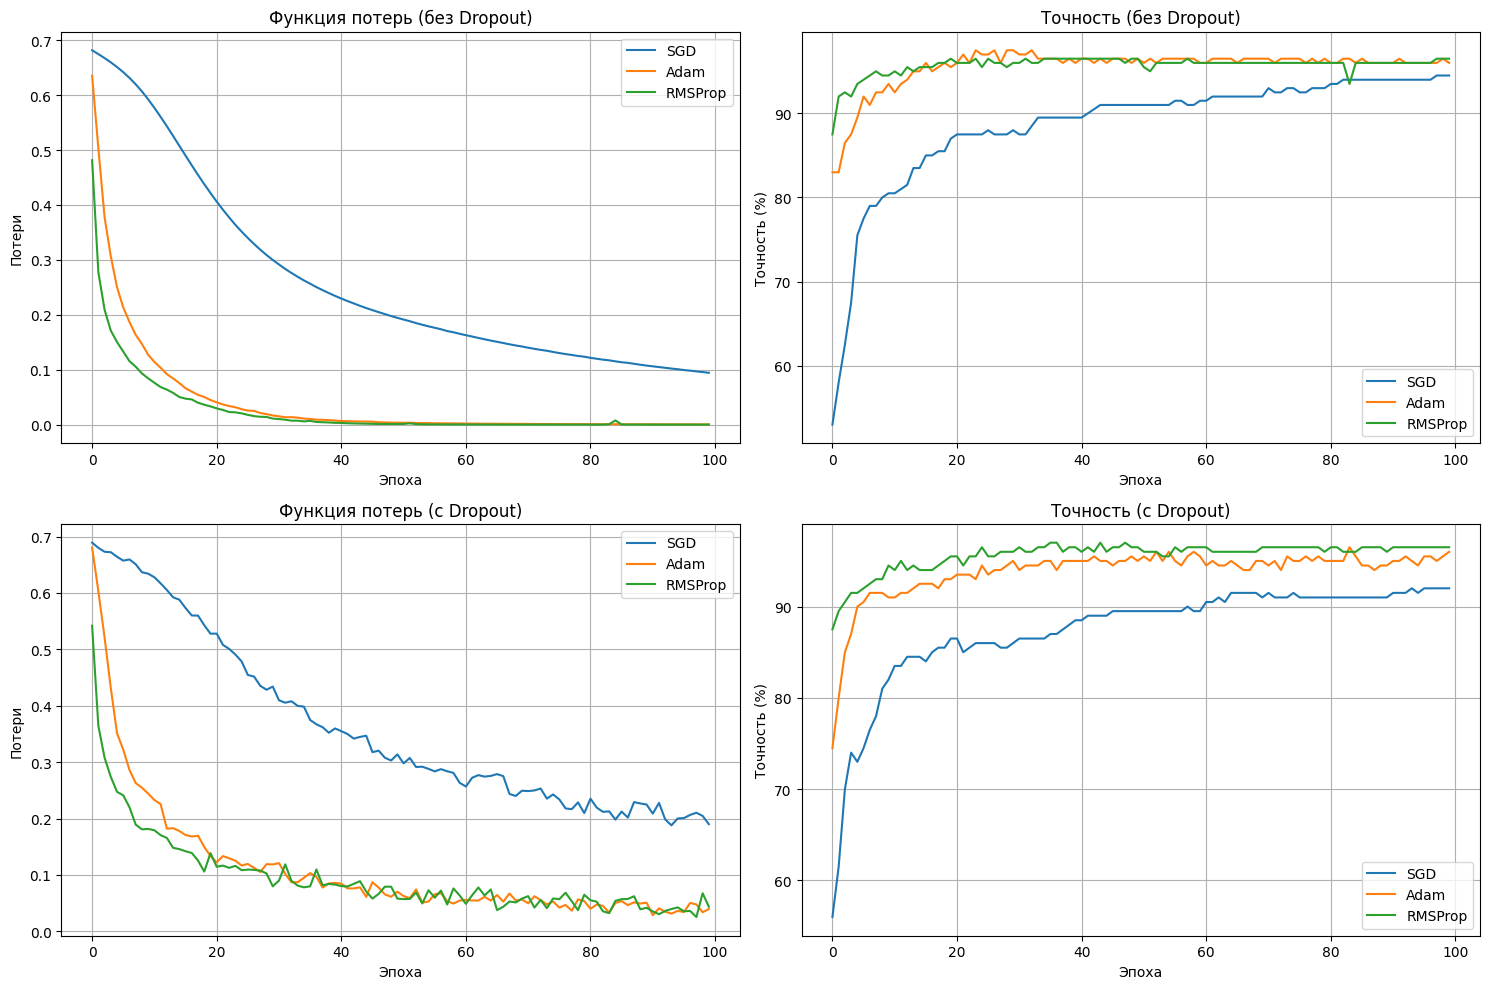

In [94]:
plt.figure(figsize=(15, 10))

# Графики без Dropout
plt.subplot(2, 2, 1)
for name, result in results_without_dropout.items():
    plt.plot(result['train_losses'], label=f'{name}')
plt.title('Функция потерь (без Dropout)')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for name, result in results_without_dropout.items():
    plt.plot(result['test_accuracies'], label=f'{name}')
plt.title('Точность (без Dropout)')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()
plt.grid(True)

# Графики с Dropout
plt.subplot(2, 2, 3)
for name, result in results_with_dropout.items():
    plt.plot(result['train_losses'], label=f'{name}')
plt.title('Функция потерь (с Dropout)')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for name, result in results_with_dropout.items():
    plt.plot(result['test_accuracies'], label=f'{name}')
plt.title('Точность (с Dropout)')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**<span style="font-size: 20px;">№7. Сравнение итоговой точности</span>**

In [95]:
print("\nБЕЗ DROPOUT:")
for name, result in results_without_dropout.items():
    print(f"{name}: {result['final_accuracy']:.2f}%")

print("\nС DROPOUT:")
for name, result in results_with_dropout.items():
    print(f"{name}: {result['final_accuracy']:.2f}%")


БЕЗ DROPOUT:
SGD: 94.50%
Adam: 96.00%
RMSProp: 96.50%

С DROPOUT:
SGD: 92.00%
Adam: 96.00%
RMSProp: 96.50%


**<span style="font-size: 20px;">№8. Дополнительное задание</span>**

In [96]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)

**<span style="font-size: 16px;">Загрузка и подготовка MNIST</span>**

In [97]:
# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Нормализация
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot кодирование меток
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Размер обучающей выборки:", x_train.shape)
print("Размер тестовой выборки:", x_test.shape)

Размер обучающей выборки: (60000, 28, 28)
Размер тестовой выборки: (10000, 28, 28)


In [98]:
def create_model(optimizer, use_dropout=False):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(128, activation='relu'))
    
    if use_dropout:
        model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    
    if use_dropout:
        model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [99]:
optimizer_factories = {
    "SGD": lambda: SGD(learning_rate=0.01),
    "Adam": lambda: Adam(),
    "RMSProp": lambda: RMSprop()
}

In [100]:
print("MNIST — обучение БЕЗ Dropout\n")

history_no_dropout = {}

for name, opt_fn in optimizer_factories.items():
    print(f"Оптимизатор: {name}")
    model = create_model(opt_fn(), use_dropout=False)
    history = model.fit(
        x_train, y_train,
        epochs=5,
        batch_size=128,
        validation_data=(x_test, y_test),
        verbose=1
    )
    history_no_dropout[name] = history
    print("-" * 50)

MNIST — обучение БЕЗ Dropout

Оптимизатор: SGD


C:\Users\PC1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\PC1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6975 - loss: 1.2492 - val_accuracy: 0.8575 - val_loss: 0.5993
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8716 - loss: 0.4992 - val_accuracy: 0.8901 - val_loss: 0.4061
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8919 - loss: 0.3918 - val_accuracy: 0.8999 - val_loss: 0.3499
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9022 - loss: 0.3470 - val_accuracy: 0.9083 - val_loss: 0.3179
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9086 - loss: 0.3197 - val_accuracy: 0.9161 - val_loss: 0.2956
--------------------------------------------------
Оптимизатор: Adam
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9044 - loss: 0.3346 - val_accuracy: 0.9543 - val_loss: 0.1529
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9613 - loss: 0.1328 - val_accuracy: 0.9673 - val_loss: 0.1094
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━

In [101]:
print("\nMNIST — обучение С Dropout\n")

history_dropout = {}

for name, opt_fn in optimizer_factories.items():
    print(f"Оптимизатор: {name}")
    model = create_model(opt_fn(), use_dropout=True)
    history = model.fit(
        x_train, y_train,
        epochs=5,
        batch_size=128,
        validation_data=(x_test, y_test),
        verbose=1
    )
    history_dropout[name] = history
    print("-" * 50)


MNIST — обучение С Dropout

Оптимизатор: SGD
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.3468 - loss: 1.8949 - val_accuracy: 0.7562 - val_loss: 1.1163
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5970 - loss: 1.2282 - val_accuracy: 0.8461 - val_loss: 0.6523
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.6941 - loss: 0.9447 - val_accuracy: 0.8776 - val_loss: 0.4972
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7455 - loss: 0.8021 - val_accuracy: 0.8899 - val_loss: 0.4235
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7774 - loss: 0.7134 - val_accuracy: 0.8978 - val_loss: 0.3776
--------------------------------------------------
Оптимизатор: Adam
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.7676 - loss: 0.7390 - val_accuracy: 0.9336 - val_loss: 0.2302
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.8981 - loss: 0.3605 - val_accuracy: 0.9482 -